In [ ]:
import pandas as pd
import numpy as np
import IPython.display
import json
from pathlib import Path
import torchaudio
from sklearn.model_selection import train_test_split
import sys
import os, json, math, re
from tqdm import tqdm
import torch
import librosa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE = "/content/drive/MyDrive/UiT_task"
# save_path = save_path = Path('/content/drive/My Drive/UiT_task/data')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/UiT_task/train_dm.csv', sep='\t')

In [ ]:

# mapping to correct path in my drive shortcut of dataset
base_old = "/content/drive/My Drive/type3/data/"
base_new = {
    "dementia": "/content/drive/MyDrive/UiT_task/dementia/",
    "nodementia": "/content/drive/MyDrive/UiT_task/nodementia/"
}
def fix_path(row):
    new_base = base_new.get(row['label'].lower(), None)
    if new_base and row['path'].startswith(base_old):
        relative = row['path'][len(base_old):]
        return new_base + relative.split('/', 1)[-1]
    return row['path']
train['fixed_path'] = train.apply(fix_path, axis=1)


In [ ]:
!pip -q install openai-whisper pandas tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 17.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip -q install faster-whisper pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.8/38.8 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.6 MB/s eta 0:00:00


In [ ]:
from faster_whisper import WhisperModel
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Sep 17 10:55:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
COMPUTE_TYPE = "float16" if DEVICE == "cuda" else "int8"

from faster_whisper import WhisperModel
fw_model = WhisperModel("medium", device=DEVICE, compute_type=COMPUTE_TYPE)

import whisper
ow_model = whisper.load_model("medium")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

vocabulary.txt: 0.00B [00:00, ?B/s]

model.bin:   0%|          | 0.00/1.53G [00:00<?, ?B/s]

100%|█████████████████████████████████████| 1.42G/1.42G [00:18<00:00, 82.2MiB/s]


In [ ]:
train.columns

Index(['file', 'label', 'path', 'fixed_path'], dtype='object')

#Whisper transcribe

In [ ]:

# ------------------------- CONFIG -------------------------

CSV_OUT  = "/content/drive/MyDrive/UiT_task/UiT_asr_words_3runs_medium.csv"
MODEL_SZ = "medium.en"
LANG     = 'en'
PRESENCE_THR = 0.50             # word considered present if max prob >= this
TIMING_DRIFT_THR_S = 0.40       # if start-time differs >= this across runs, flag
PROB_STD_THR = 0.25             # std-dev threshold for probability variance flag

# A = reference (try single pass; fallback if incomplete)
CFG_A = dict(vad_filter=True,  beam_size=1, temperature=0.0)

# B = slightly stochastic (mild randomness)
CFG_B = dict(vad_filter=True,  beam_size=1, temperature=0.3)

# C = segmentation variant (no VAD)
CFG_C = dict(vad_filter=False, beam_size=1, temperature=0.0)


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
COMPUTE_TYPE = "float16" if DEVICE == "cuda" else "int8"

# ----------------------- HELPERS --------------------------
def norm_tok(s):
    return re.sub(r"[^\w']+", "", (s or "").strip().lower())

def run_whisper_words(model, audio_path, lang, **cfg):
    segs, info = model.transcribe(
        audio_path,
        language=lang, task="transcribe",
        word_timestamps=True,
        # softer skip filters
        no_speech_threshold=0.01,
        log_prob_threshold=-1.0,
        compression_ratio_threshold=2.6,
        condition_on_previous_text=False,
        **cfg
    )
    text_parts, words_out = [], []
    for s in segs:
        text_parts.append(s.text or "")
        if s.words:
            for w in s.words:
                words_out.append({
                    "word": w.word,
                    "start": float(w.start) if w.start is not None else None,
                    "end":   float(w.end)   if w.end   is not None else None,
                    "prob":  float(w.probability) if w.probability is not None else None
                })
    text = "".join(text_parts).strip()
    mean_prob = (sum(w["prob"] for w in words_out if w["prob"] is not None) /
                 max(1, sum(1 for w in words_out if w["prob"] is not None)))
    return text, words_out, mean_prob


def words_to_maps(words):
    """
    Lookup
    - max probability per normalized token
    - first-start-time per normalized token (for timing drift checks)
    """
    max_prob = {}
    first_start = {}
    for w in words:
        t = norm_tok(w["word"])
        if not t:
            continue
        p = w["prob"] if w["prob"] is not None else 0.0
        s = w["start"] if w["start"] is not None else None
        max_prob[t] = max(max_prob.get(t, 0.0), p)
        if s is not None and t not in first_start:
            first_start[t] = float(s)
    return max_prob, first_start

def majority_vote_presence(tokens, maps_list, thr=PRESENCE_THR):
    """
    For union of tokens across runs, compute presence vector [A,B,C] and stats.
    maps_list = [(prob_map_A, start_map_A), (prob_map_B, start_map_B), (prob_map_C, start_map_C)]
    """
    prob_maps = [m[0] for m in maps_list]
    start_maps = [m[1] for m in maps_list]
    all_tokens = set()
    for pm in prob_maps:
        all_tokens.update(pm.keys())

    rows = []
    for t in sorted(all_tokens):
        probs = [pm.get(t, 0.0) for pm in prob_maps]
        present = [int(p >= thr) for p in probs]
        n_present = sum(present)
        starts = [start_maps[i].get(t, None) for i in range(3)]
        # timing drift: only between runs where token is present
        present_starts = [s for (s, pres) in zip(starts, present) if pres and s is not None]
        drift = (max(present_starts) - min(present_starts)) if len(present_starts) >= 2 else 0.0
        rows.append({
            "token": t,
            "present_A": present[0], "present_B": present[1], "present_C": present[2],
            "probs": probs,
            "prob_mean": float(np.mean(probs)),
            "prob_std": float(np.std(probs)),
            "n_present": int(n_present),
            "start_times": starts,
            "timing_drift_s": float(drift)
        })
    return rows


def decode_is_complete(words, duration_s, slack=1.5):
    """True if the last decoded word ends within 'slack' seconds of the file end."""
    if not words: return False
    last_end = max(float(w.get("end") or 0.0) for w in words)
    return (duration_s - last_end) <= slack

def stitch_words(all_words):
    """Sort and dedupe overlapped-window words by keeping the higher-prob duplicate."""
    all_words = sorted(all_words, key=lambda w: (w["start"] or 0.0, -(w["prob"] or 0.0)))
    out = []
    for w in all_words:
        if out and abs((w["start"] or 0)-(out[-1]["start"] or 0)) < 0.10 and (w["word"] == out[-1]["word"]):
            # keep the one with higher prob
            if (w["prob"] or 0) > (out[-1]["prob"] or 0): out[-1] = w
        else:
            out.append(w)
    return out

def transcribe_full_coverage(model, audio_path, lang, win_s=30.0, overlap_s=5.0, **cfg):
    """Guarantee coverage via fixed, overlapping windows; stitch to one word list."""
    y, sr = librosa.load(audio_path, sr=16000, mono=True)
    n = len(y)
    hop = int((win_s - overlap_s) * sr)
    win = int(win_s * sr)
    t0 = 0; words_all = []
    while t0 < n:
        t1 = min(t0 + win, n)
        y_slice = y[t0:t1]
        offset  = t0 / sr

        segs, _ = model.transcribe(
            y_slice,
            language=lang, task="transcribe",
            word_timestamps=True,
            vad_filter=False,
            condition_on_previous_text=False,
            **cfg
        )
        for s in segs:
            if s.words:
                for w in s.words:
                    words_all.append({
                        "word": w.word,
                        "start": (w.start or 0.0) + offset,
                        "end":   (w.end   or 0.0) + offset,
                        "prob":  float(w.probability or 0.0),
                    })
        if t1 == n: break
        t0 += hop

    words_all = stitch_words(words_all)
    text = " ".join([w["word"] for w in words_all]).strip()
    mean_prob = (sum(w["prob"] for w in words_all if w["prob"] is not None) /
                 max(1, sum(1 for w in words_all if w["prob"] is not None)))
    return text, words_all, mean_prob


# ------------------------- MAIN ---------------------------

records = []
for i, row in tqdm(train.iterrows(), total=len(train)):
    audio = row['fixed_path']
    try:

        duration_s = librosa.get_duration(path=audio)

        # --- Run A ---
        text_A, words_A, mean_A = run_whisper_words(fw_model, audio, LANG, **CFG_A)
        if not decode_is_complete(words_A, duration_s):
            text_A, words_A, mean_A = transcribe_full_coverage(fw_model, audio, LANG, **CFG_A)

        # --- Run B ---
        text_B, words_B, mean_B = run_whisper_words(fw_model, audio, LANG, **CFG_B)
        if not decode_is_complete(words_B, duration_s):
            text_B, words_B, mean_B = transcribe_full_coverage(fw_model, audio, LANG, **CFG_B)

        # --- Run C ---
        text_C, words_C, mean_C = run_whisper_words(fw_model, audio, LANG, **CFG_C)
        if not decode_is_complete(words_C, duration_s):
          text_C, words_C, mean_C = transcribe_full_coverage(fw_model, audio, LANG, **CFG_C)


        # Build maps
        mapA = words_to_maps(words_A)
        mapB = words_to_maps(words_B)
        mapC = words_to_maps(words_C)

        # Majority/variance/timing analysis
        rows = majority_vote_presence(tokens=None, maps_list=[mapA, mapB, mapC], thr=PRESENCE_THR)
        stats_df = pd.DataFrame(rows)

        # Mismatch rules:
        #  - flaky by presence: appears in <= 1 of 3 runs
        #  - OR high probability variance across runs
        #  - OR timing drift >= threshold (when present multiple runs)
        mismatch_mask = (
            (stats_df["n_present"] <= 1) |
            (stats_df["prob_std"] >= PROB_STD_THR) |
            (stats_df["timing_drift_s"] >= TIMING_DRIFT_THR_S)
        )
        mismatch_tokens = stats_df.loc[mismatch_mask, "token"].tolist()

        # Aggregate file-level stats
        mean_word_prob_3_run = float(np.mean([mean_A, mean_B, mean_C]))
        n_words_A = len(words_A); n_words_B = len(words_B); n_words_C = len(words_C)
        # reference text (A), store others as alternates
        text_3_run = text_A
        records.append({
            "file": row["file"],
            "label": row["label"],
            "path": row["fixed_path"],

            # Run A (greedy)
            "text_A": text_A,
            "mean_word_prob_A": mean_A,
            "n_words_A": n_words_A,
            "words_json_A": json.dumps(words_A, ensure_ascii=False),

            # Run B (stochastic)
            "text_B": text_B,
            "mean_word_prob_B": mean_B,
            "n_words_B": n_words_B,
            "words_json_B": json.dumps(words_B, ensure_ascii=False),

            # Run C (no VAD / segmentation variant)
            "text_C": text_C,
            "mean_word_prob_C": mean_C,
            "n_words_C": n_words_C,
            "words_json_C": json.dumps(words_C, ensure_ascii=False),

            # Combined / analysis
            "text_3_run": text_3_run,
            "mean_word_prob_3_run": mean_word_prob_3_run,
            "n_disagree_tokens": len(mismatch_tokens),
            "disagree_tokens_json": json.dumps(mismatch_tokens, ensure_ascii=False),
            "words_stats_json": stats_df.to_json(orient="records")
        })

    except Exception as e:
        records.append({
            "file": row["file"],
            "label": row["label"],
            "path": row["fixed_path"],
            # mark error, keep placeholders
            "error": str(e),
            "text_A": "", "text_B": "", "text_C": "",
            "mean_word_prob_A": None, "mean_word_prob_B": None, "mean_word_prob_C": None,
            "n_words_A": 0, "n_words_B": 0, "n_words_C": 0,
            "words_json_A": "[]", "words_json_B": "[]", "words_json_C": "[]",
            "text_3_run": "",
            "mean_word_prob_3_run": None,
            "n_disagree_tokens": None,
            "disagree_tokens_json": "[]",
            "words_stats_json": "[]"
        })

asr_df_medium = pd.DataFrame(records)
asr_df_medium.to_csv(CSV_OUT, index=False)
#asr_df.head()


100%|██████████| 227/227 [30:56<00:00,  8.18s/it]


In [ ]:
#lang=pd.read_csv("/content/drive/MyDrive/UiT_task/UiT_asr_words_with_alt.csv")

In [ ]:
#df_medium=pd.merge(asr_df_medium, lang[['file', 'label', 'path', 'language', 'language_conf']],on=['file', 'label', 'path'], how = 'inner')
#language detection was run previously, but because all are english (except the removed 10 instances in Welsh, this step is not necessary)
df_medium = asr_df_medium.copy()

# Suspicios files

In [ ]:
def token_stats_from_row(row, presence_thr=0.50, timing_drift_thr=0.40):
    import json, re, numpy as np, pandas as pd
    def norm_tok(s): return re.sub(r"[^\w']+", "", (s or "").strip().lower())
    def words_to_maps(words):
        mp, st = {}, {}
        for w in words:
            t = norm_tok(w["word"]);  p = float(w.get("prob") or 0.0); s = w.get("start")
            if not t: continue
            mp[t] = max(mp.get(t, 0.0), p)
            if s is not None and t not in st: st[t] = float(s)
        return mp, st

    A = json.loads(row["words_json_A"]); B = json.loads(row["words_json_B"]); C = json.loads(row["words_json_C"])
    prob_maps = []; start_maps = []
    for words in (A,B,C):
        mp, st = words_to_maps(words)
        prob_maps.append(mp); start_maps.append(st)

    tokens = set().union(*[mp.keys() for mp in prob_maps])
    rows = []
    for t in tokens:
        probs = [mp.get(t, 0.0) for mp in prob_maps]
        pres  = [int(p >= presence_thr) for p in probs]
        n_pres = sum(pres)
        starts = [start_maps[i].get(t, None) for i in range(3)]
        pres_starts = [s for s,p in zip(starts, pres) if p and s is not None]
        drift = (max(pres_starts)-min(pres_starts)) if len(pres_starts)>=2 else 0.0
        rows.append({
            "token": t,
            "n_present": n_pres,
            "prob_std": float(np.std(probs)),
            "timing_drift_s": float(drift),
        })
    return pd.DataFrame(rows)

def file_suspects_summary(row,
                          prob_std_thr=0.25,
                          timing_drift_thr=0.40,
                          presence_flaky_thresh=1):
    s = token_stats_from_row(row)
    # token-level flags
    s["flag_presence_flaky"] = (s["n_present"] <= presence_flaky_thresh)
    s["flag_prob_var"]      = (s["prob_std"] >= prob_std_thr)
    s["flag_timing_drift"]  = (s["timing_drift_s"] >= timing_drift_thr)
    # counts
    n_flaky = int(s["flag_presence_flaky"].sum())
    n_var   = int(s["flag_prob_var"].sum())
    n_drift = int(s["flag_timing_drift"].sum())
    n_mismatch = int((s["flag_presence_flaky"] | s["flag_prob_var"] | s["flag_timing_drift"]).sum())
    return n_mismatch, n_flaky, n_var, n_drift, s


In [ ]:
def compute_file_level_scores(asr_df):
    rows = []
    for _, row in asr_df.iterrows():
        try:
            n_mismatch, n_flaky, n_var, n_drift, s = file_suspects_summary(row)
        except Exception as e:
            rows.append({"file": row.get("file"), "path": row["path"], "error": str(e)})
            continue

        # basic denominators
        n_words_mean = np.mean([row["n_words_A"], row["n_words_B"], row["n_words_C"]])
        dur = row.get("duration_s", np.nan)  # if you have it

        # normalized rates
        mismatch_rate = n_mismatch / max(1, n_words_mean)
        flaky_rate    = n_flaky   / max(1, n_words_mean)
        var_rate      = n_var     / max(1, n_words_mean)
        drift_rate    = n_drift   / max(1, n_words_mean)

        # chaos score (tweak weights as you like)
        chaos = (0.5*mismatch_rate +
                 0.2*flaky_rate +
                 0.2*var_rate +
                 0.1*drift_rate)

        rows.append({
            "file": row.get("file"),
            "label": row.get("label"),
            "path": row["path"],
            "n_mismatch": n_mismatch,
            "n_flaky": n_flaky,
            "n_var": n_var,
            "n_drift": n_drift,
            "n_words_mean": n_words_mean,
            "mismatch_rate": mismatch_rate,
            "chaos_score": chaos
        })
    return pd.DataFrame(rows)

file_scores = compute_file_level_scores(df_medium)
file_scores = file_scores.sort_values("chaos_score", ascending=False)
file_scores.head(10)


,file,label,path,n_mismatch,n_flaky,n_var,n_drift,n_words_mean,mismatch_rate,chaos_score,error
12,emilegriffith_5,dementia,/content/drive/MyDrive/UiT_task/dementia/Emile...,9.0,8.0,2.0,0.0,23.000000,0.391304,0.282609,NaN
77,JackWebster_5,dementia,/content/drive/MyDrive/UiT_task/dementia/Jack ...,16.0,10.0,7.0,4.0,59.333333,0.269663,0.198876,NaN
59,JimNeidhart_10,dementia,/content/drive/MyDrive/UiT_task/dementia/Jim N...,10.0,8.0,5.0,1.0,39.666667,0.252101,0.194118,NaN
86,RayDolby_0,dementia,/content/drive/MyDrive/UiT_task/dementia/Ray D...,23.0,12.0,8.0,9.0,88.000000,0.261364,0.186364,NaN
51,CharlesBronson_10,dementia,/content/drive/MyDrive/UiT_task/dementia/Charl...,21.0,10.0,10.0,6.0,89.000000,0.235955,0.169663,NaN
72,jessehelms_5_1,dementia,/content/drive/MyDrive/UiT_task/dementia/Jesse...,15.0,6.0,5.0,7.0,72.666667,0.206422,0.143119,NaN
44,galesayers_5_1,dementia,/content/drive/MyDrive/UiT_task/dementia/Gale ...,19.0,11.0,6.0,6.0,97.333333,0.195205,0.138699,NaN
46,galesayers_0,dementia,/content/drive/MyDrive/UiT_task/dementia/Gale ...,31.0,23.0,4.0,5.0,158.666667,0.195378,0.134874,NaN
81,TrevorPeacock_5,dementia,/content/drive/MyDrive/UiT_task/dementia/Trevo...,17.0,9.0,3.0,6.0,85.333333,0.199219,0.134766,NaN
152,HankAaron_2,nodementia,/content/drive/MyDrive/UiT_task/nodementia/Han...,16.0,4.0,5.0,7.0,79.666667,0.200837,0.131799,NaN


In [ ]:
file_scores = file_scores[file_scores['label'].notna()]

In [ ]:
from IPython.display import HTML

cols = ['file','label','n_mismatch','n_flaky','n_var','n_drift',
        'n_words_mean','mismatch_rate','chaos_score']

styled = (
    file_scores[cols].head(10)
    .round(2)
    .style
    .set_caption("Top 10 Files by Chaos Score")
    .format(precision=2)
    .background_gradient(subset=['chaos_score'], cmap='Reds')
    .bar(subset=['mismatch_rate'], color='#ffa07a')
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'),
                                     ('font-weight','bold'),
                                     ('background-color','#f0f0f0')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])
)
HTML(styled.to_html())


,file,label,n_mismatch,n_flaky,n_var,n_drift,n_words_mean,mismatch_rate,chaos_score
12,emilegriffith_5,dementia,9.00,8.00,2.00,0.00,23.00,0.39,0.28
77,JackWebster_5,dementia,16.00,10.00,7.00,4.00,59.33,0.27,0.20
59,JimNeidhart_10,dementia,10.00,8.00,5.00,1.00,39.67,0.25,0.19
86,RayDolby_0,dementia,23.00,12.00,8.00,9.00,88.00,0.26,0.19
51,CharlesBronson_10,dementia,21.00,10.00,10.00,6.00,89.00,0.24,0.17
72,jessehelms_5_1,dementia,15.00,6.00,5.00,7.00,72.67,0.21,0.14
44,galesayers_5_1,dementia,19.00,11.00,6.00,6.00,97.33,0.20,0.14
46,galesayers_0,dementia,31.00,23.00,4.00,5.00,158.67,0.20,0.13
81,TrevorPeacock_5,dementia,17.00,9.00,3.00,6.00,85.33,0.20,0.13
152,HankAaron_2,nodementia,16.00,4.00,5.00,7.00,79.67,0.20,0.13


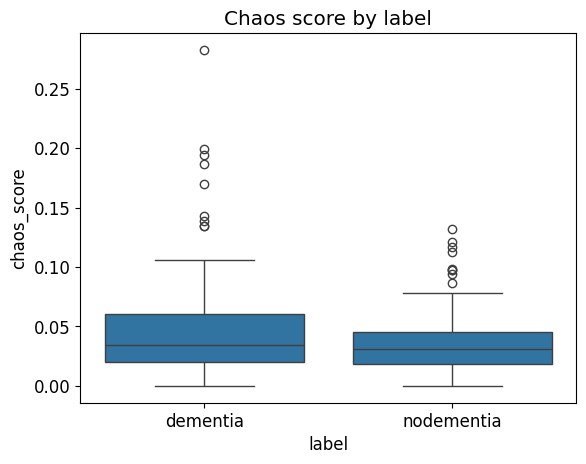

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=file_scores, x="label", y="chaos_score")
plt.title("Chaos score by label")
plt.show()

#Exploring the suspects


In [ ]:
df_medium[df_medium['file']=='JackWebster_5'].text_C.values

array(["They don't know the motor spaces well as you do, but I've been over them in helicopters. And on the Seabood side, there must be 450 square miles of land which is available now for national parks, where there has been no logging, except maybe 100 years ago, or during the war when there was all kinds of fringelogs."],
      dtype=object)

In [ ]:
df_medium[df_medium['file']=='JackWebster_5'].text_A.values

array(["They don't know the motor spaces well as you do, but I've been over them in helicopters. And on the Seabood side, there must be 450 square miles of land which is available now for national parks, where there has been no logging, except maybe 100 years ago, or during the war when there was all kinds of fringelogs."],
      dtype=object)

In [ ]:
df_medium[df_medium['file']=='JackWebster_5'].text_B.values

array(["don't know the motor spaces well as you do but I've been over them in helicopters and on the seaboard side there must be 450 square miles of land which is available now for national parks where there has been no water except maybe a hundred years ago or during the war when there was all kinds of fringe logs"],
      dtype=object)

In [ ]:
df_medium[df_medium["file"]=="JackWebster_5"].path.values

array(['/content/drive/MyDrive/UiT_task/dementia/Jack Webster/JackWebster_5.wav'],
      dtype=object)

In [ ]:
list(df_medium[df_medium["file"]=="emilegriffith_5"].text_A.values)

["I didn't know that I understood it a little Spanish, but at the time, I knew my conment faggot, and I wasn't nobody."]

In [ ]:
text_a = list(df_medium[df_medium["file"]=="emilegriffith_5"].text_A.values)
text_b = list(df_medium[df_medium["file"]=="emilegriffith_5"].text_B.values)
text_c = list(df_medium[df_medium["file"]=="emilegriffith_5"].text_C.values)
all_text = " ".join(text_a + text_b + text_c)
words = re.findall(r"[a-zA-Z']+", all_text.lower())
unique_words = sorted(set(words))
print("Unique words:", unique_words)


Unique words: ['a', 'and', 'at', 'but', 'bye', 'conga', "didn't", 'english', 'i', 'knew', 'know', 'little', 'mens', 'my', 'nobody', 'package', 'spanish', 'that', 'the', 'time', 'understand', 'understood', "wasn't"]


In [ ]:

row = df_medium[df_medium["file"]=="emilegriffith_5"].iloc[0]
n_mismatch, n_flaky, n_var, n_drift, s = file_suspects_summary(row)

s["score"] = (s["n_present"]<=1).astype(int)*3 + \
             (s["prob_std"]>=0.25).astype(int)*2 + \
             (s["timing_drift_s"]>=0.40).astype(int)*2 + \
             (s["n_present"]==2).astype(int)

top_targets = s.sort_values(["score","prob_std","timing_drift_s"], ascending=False)["token"].tolist()[:20]


In [ ]:
# suspects = s[(s.flag_presence_flaky) | (s.flag_prob_var) | (s.flag_timing_drift)]
# suspects = s[
#     (s["flag_presence_flaky"]) |
#     (s["prob_std"] >= 0.25) |
#     (s["timing_drift_s"] >= 0.40)
# ].copy()

# suspects["score"] = \
#     (s["flag_presence_flaky"]).astype(int)*3 + \
#     (s["prob_std"]>=0.25).astype(int)*2 + \
#     (s["timing_drift_s"]>=0.40).astype(int)*2 + \
#     (s["n_present"]==2).astype(int)

# # build the token list for XAI
# MISMATCH_WORDS = suspects.sort_values(
#     ["score","prob_std","timing_drift_s"], ascending=False
# )["token"].tolist()

# print(MISMATCH_WORDS)


['little', 'faggot', 'spaghetti', 'love', 'mark', 'a', 'made', 'my', 'conment', 'home', 'combat', 'it']


# XAI on emilegriffith_5 (highest suspecios score)

In [ ]:


from sklearn.linear_model import Ridge, LogisticRegression
from collections import defaultdict
from sklearn.preprocessing import StandardScaler


# ----------------- PARAMS -----------------
AUDIO_PATH  = "/content/drive/MyDrive/UiT_task/dementia/Emile Griffith/emilegriffith_5.wav"
LANG        = "en"
MODEL_NAME  = "medium.en"
WIN_MS      = 250            # https://www.nature.com/articles/s41598-025-03444-3 for the 250 ms window referense
HOP_MS      = 125
NSAMPLES    = 400            # number of masked variants (600, 800, 1000)
MASK_FRAC   = 0.30           # fraction of windows to mute per sample
ATTEN_DB    = -30            # attenuation level
CROSSFADE   = 10             # crossfade at mask edges for smoother masking
WORD_PROB_T = 0.50           # present if prob >= this
RANDOM_SEED = 0


def norm_tok(s): return re.sub(r"[^\w']+", "", (s or "").strip().lower())
def segment_samples(n, sr, win_ms=250, hop_ms=125):
    win = int(sr * win_ms/1000.0)
    hop = int(sr * hop_ms/1000.0)
    idx = []
    i = 0
    while i + win <= n:
        idx.append((i, i+win))
        i += hop
    if not idx:
        raise ValueError("Audio too short for given window/hop.")
    return np.array(idx)  # shape [K,2]

def crossfade_attenuate(y, spans, sr, atten_db=-30, xf_ms=10):
    """short crossfades to reduce artifacts"""
    y2 = y.copy()
    gain = 10**(atten_db/20.0)
    xf = int(sr*xf_ms/1000.0)
    for (a, b) in spans:
        a = max(0, a); b = min(len(y2), b)
        if b <= a: continue
        # fade-out into attenuated level
        if xf > 0:
            L = min(xf, b-a)
            fade = np.linspace(1.0, gain, L, dtype=y2.dtype)
            y2[a:a+L] *= fade
        # sustained attenuated section
        mid_start = a+xf
        mid_end   = max(mid_start, b-xf)
        if mid_end > mid_start:
            y2[mid_start:mid_end] *= gain
        # fade-in back to 1.0
        if xf > 0 and b-xf >= a:
            L = min(xf, b-a)
            fade = np.linspace(gain, 1.0, L, dtype=y2.dtype)
            y2[b-L:b] *= fade
    return y2

def run_whisper(fw_model, y, lang):
    segs, info = fw_model.transcribe(
        y, word_timestamps=True, language=lang,
        vad_filter=True, beam_size=1, temperature=0.0, task="transcribe"
    )
    words = []
    for s in segs:
        if s.words:
            words.extend(s.words)
    return words

def word_presence_scores(words):
    d = defaultdict(float)
    for w in words:
        tok = norm_tok(getattr(w, "word", "") or "")
        prob = float(getattr(w, "probability", 0.0) or 0.0)
        if tok:
            d[tok] = max(d[tok], prob)
    return d

# ----------------- LOAD AUDIO AND BASELINE -----------------
y, sr = librosa.load(AUDIO_PATH, sr=16000, mono=True)
idx = segment_samples(len(y), sr, WIN_MS, HOP_MS)
K = len(idx)
print(f"Windows: {K}, audio duration: {len(y)/sr:.2f}s")

fw_model = WhisperModel(MODEL_NAME, device="cuda", compute_type="float16")

base_words = run_whisper(fw_model, y, LANG)
base_map   = word_presence_scores(base_words)
print("Baseline decoded, unique words:", len(base_map))

targets = [w for w in unique_words if norm_tok(w)] # can change to top_targets if we only want the top mismatched words, not all
targets = list(dict.fromkeys(map(norm_tok, targets)))

# ----------------- GENERATE MASKS AND TRANSCRIBE -----------------
rng = np.random.default_rng(RANDOM_SEED)
masks = (rng.random((NSAMPLES, K)) < MASK_FRAC).astype(np.int8)  # 1=mask window
hyps_maps = []

print("Running perturbed decodes . . .")
for m in tqdm(masks, unit="mask"):
    spans = [tuple(idx[i]) for i in np.where(m==1)[0]]
    y_masked = crossfade_attenuate(y, spans, sr, atten_db=ATTEN_DB, xf_ms=CROSSFADE)
    words = run_whisper(fw_model, y_masked, LANG)
    hyps_maps.append(word_presence_scores(words))

# ----------------- FIT LOCAL SURROGATES PER WORD -----------------
results_medium_emilegriffith_5 = {}
X = (1 - masks)  # feature=1 - unmasked"

def labels_for(word_map_list, target_norm, thr=WORD_PROB_T):
    y_bin = np.array([(wm.get(target_norm, 0.0) >= thr) for wm in word_map_list], dtype=int)
    return y_bin

for w in targets:

    y_bin = labels_for(hyps_maps, w, thr=WORD_PROB_T)
    p = y_bin.mean()

    if 0.05 < p < 0.95:
        # Logistic on binary labels
        clf = LogisticRegression(
            penalty="l1", solver="liblinear", C=0.5,
            class_weight="balanced", max_iter=200
        )
        clf.fit(X, y_bin)
        coef = clf.coef_.ravel()
        note = f"LogReg (pos rate {p:.2f})"
    else:
        # Too imbalanced case - Ridge on continuous probabilities
        y_cont = np.array([wm.get(w, 0.0) for wm in hyps_maps], float)
        if np.all(y_cont == 0):
            results_medium_emilegriffith_5[w] = {"coef": np.zeros(K), "note": "No signal (all 0)"}
            continue
        reg = Ridge(alpha=1.0)
        reg.fit(X, y_cont)
        coef = reg.coef_.ravel()
        note = f"Ridge (mean prob {y_cont.mean():.2f})"

    results_medium_emilegriffith_5[w] = {"coef": coef, "note": note}


Windows: 79, audio duration: 10.00s
Baseline decoded, unique words: 20
Running perturbed decodes . . .


100%|██████████| 400/400 [03:32<00:00,  1.88mask/s]


In [ ]:
# results = results_medium_emilegriffith_5.copy()
## so that it will be reusable with name 'results', if needed another file exploration is needed
## in that case, find and replace all results_medium_emilegriffith_5 to results, and uncomment the line above

# XAI results

In [ ]:

# import pickle
# with open('/content/drive/MyDrive/UiT_task/emilegriffith_5_medium.pkl', 'wb') as f:
#     pickle.dump(results, f)

# with open('/content/drive/MyDrive/UiT_task/emilegriffith_5_large.pkl', 'wb') as f:
#     pickle.dump(results1, f)

# with open('/content/drive/MyDrive/UiT_task/emilegriffith_5_small.pkl', 'wb') as f:
#     pickle.dump(results_small, f)
## tried with different models, medium was the most optimal
## however, medium is also used for the A/B/C generation, so using medium model will also keep consistency

In [ ]:

def baseline_spans_for(word_norm):
    return [(float(getattr(w,"start",0.0) or 0.0), float(getattr(w,"end",0.0) or 0.0))
            for w in base_words if norm_tok(getattr(w,"word","")) == word_norm]

def in_span_mask(st,en):
    a = idx[:,0]/sr; b = idx[:,1]/sr
    return ~((b <= st) | (a >= en))

def token_metrics(word_norm):
    co = results_medium_emilegriffith_5[word_norm]["coef"]
    if co is None or not np.any(co):
        return None
    absco = np.abs(co)
    total = absco.sum() + 1e-8
    spans = baseline_spans_for(word_norm)
    in_mass = 0.0; neg_in_mass = 0.0
    for st,en in spans:
        m = in_span_mask(st,en)
        in_mass += absco[m].sum()
        neg_in_mass += np.abs(co[m][co[m] < 0]).sum()
    # concentration (how spiky)
    conc = absco.max()/total
    return {
        "strength": float(total),
        "concentration": float(conc),
        "in_span_frac": float(in_mass/total),
        "neg_in_span_frac": float(neg_in_mass/(in_mass+1e-8)),
        "model": results_medium_emilegriffith_5[word_norm]["note"],
    }


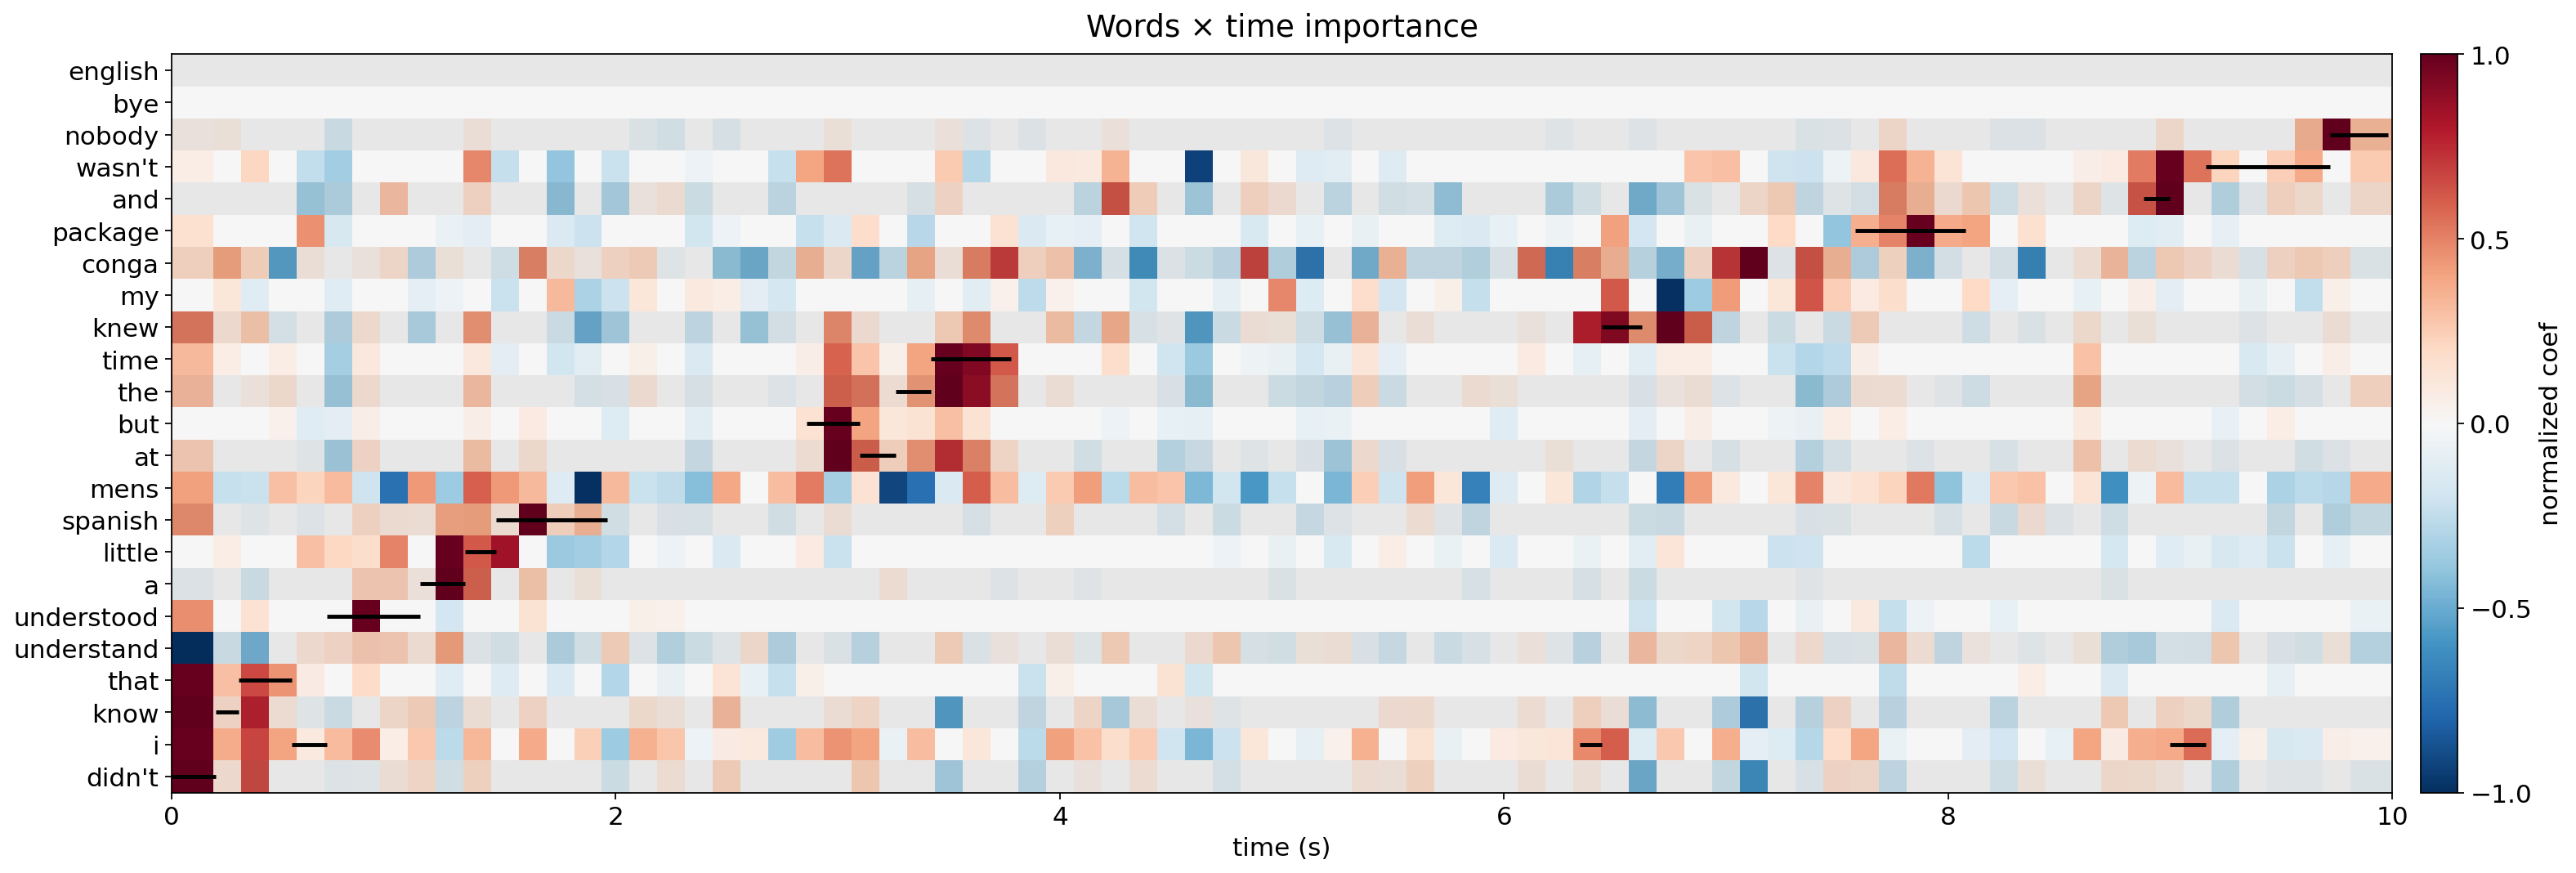

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def heatmap_words_vs_time_overlay_pretty(
    results,
    idx,
    sr,
    baseline_spans_for,
    word_list=None,
    normalize=True,
    sort_by_peak=True,
    show_spans=True,
    zero_as_white=True,
    clip_small=0.05,
    zebra_alpha=0.06,
    fontsize=14,
    dpi=160,
    title="Words × time importance"
):
    """
   time bins aligned to window edges.
   Assumptions:
      - idx[k] = [start_sample, end_sample] for column k
      - baseline_spans_for(word) returns spans in SECONDS
    """

    all_words = word_list or list(results.keys())
    labels = []
    rows = []

    if not isinstance(idx, np.ndarray):
        idx = np.asarray(idx, dtype=float)
    K = int(idx.shape[0])

    for w in all_words:
        co = results.get(w, {}).get("coef", None)
        arr = np.zeros(K, float) if co is None else np.asarray(co, dtype=float)

        if arr.size < K:
            arr = np.pad(arr, (0, K - arr.size), mode="constant")
        elif arr.size > K:
            arr = arr[:K]

        if normalize and np.any(arr):
            m = np.max(np.abs(arr))
            if m > 0:
                arr = arr / m

        # noise ~ 0
        arr[np.abs(arr) < clip_small] = 0.0

        rows.append(arr)
        labels.append(w)

    if not rows:
        print("No words to plot.")
        return None, None

    M = np.vstack(rows)  # shape = (n_words, K)

    # --------- sorting: by peak-time, then by peak magnitude ---------
    if sort_by_peak:
        has_sig  = np.any(np.abs(M) > 0, axis=1)
        # peak index among abs values; send zero-rows to the end via big index
        peak_idx = np.where(has_sig, np.argmax(np.abs(M), axis=1), 10**9)
        peak_mag = np.max(np.abs(M), axis=1)
        order = np.lexsort((-peak_mag, peak_idx))  # time first, then strength
        M = M[order]
        labels = [labels[i] for i in order]

    # --------- build time EDGES (seconds) from idx ---------
    # Safety checks
    assert np.all(idx[:, 0] <= idx[:, 1]), "Window has start - end"
    # time edges are strictly increasing
    t_edges = np.empty(K + 1, dtype=float)
    t_edges[0]  = idx[0, 0] / sr
    t_edges[-1] = idx[-1, 1] / sr
    if K > 1:
        # internal edges at midpoints between consecutive windows
        mids = (idx[:-1, 1] + idx[1:, 0]) / (2.0 * sr)
        t_edges[1:-1] = mids
        # In rare overlap/gap cases, enforce monotonicity
        np.maximum.accumulate(t_edges, out=t_edges)

    # Y edges: one unit per word row
    y_edges = np.arange(0, len(labels) + 1, dtype=float)

    # --------- figure and style ---------
    plt.rcParams.update({"font.size": fontsize})
    fig = plt.figure(figsize=(20, max(3.8, 0.30 * len(labels))), dpi=dpi)
    ax = plt.gca()

    # symmetric color scale around 0
    max_abs = float(np.max(np.abs(M))) if M.size else 1.0
    max_abs = max(max_abs, 1e-6)
    vmin, vmax = -max_abs, +max_abs

    # colormap centered at 0 (white)
    if zero_as_white:
        cmap = mpl.cm.RdBu_r
        norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    else:
        cmap = mpl.cm.coolwarm
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    # --------- draw with pcolormesh (edges - exact time mapping) ---------
    pcm = ax.pcolormesh(
        t_edges, y_edges, M,
        cmap=cmap, norm=norm, shading="auto"
    )

    #  zebra stripes to guide the eye
    if zebra_alpha > 0:
        for r in range(0, len(labels), 2):
            ax.axhspan(r, r + 1, color="k", alpha=zebra_alpha, lw=0)

    # --------- spans overlay (seconds) ---------
    if show_spans:
        x_min, x_max = t_edges[0], t_edges[-1]
        for r, w in enumerate(labels):
            try:
                for st, en in baseline_spans_for(w):
                    # clip to plot range
                    st_p = max(x_min, float(st))
                    en_p = min(x_max, float(en))
                    if en_p > st_p:
                        ax.plot([st_p, en_p], [r + 0.5, r + 0.5],
                                color="k", lw=2.2, solid_capstyle="butt")
            except Exception:
                pass

    # axes/labels
    ax.set_yticks(np.arange(len(labels)) + 0.5)
    ax.set_yticklabels(labels)
    ax.set_xlabel("time (s)")
    ax.set_title(title, pad=10)
    ax.set_xlim(t_edges[0], t_edges[-1])
    ax.set_ylim(0, len(labels))

    # colorbar with nice ticks
    cb = fig.colorbar(pcm, ax=ax, pad=0.012, fraction=0.04)
    ticks = np.round(
        np.linspace(vmin, 0, 3).tolist() + np.linspace(0, vmax, 3).tolist()[1:], 2
    )
    cb.set_ticks(sorted(set(ticks)))
    cb.set_label("normalized coef")

    plt.tight_layout()
    plt.show()
    return fig, ax


fig, ax = heatmap_words_vs_time_overlay_pretty(
    results=results_medium_emilegriffith_5,
    idx=idx,               # shape (K,2) in samples
    sr=sr,                 # sample rate
    baseline_spans_for=baseline_spans_for,
    word_list=targets,     # or None to use all keys
    normalize=True,
    sort_by_peak=True,
    show_spans=True
)


In [ ]:
def label_token(m):

    if m is None:
        return "no_signal"

    # ---- read and clamp ----
    clamp01 = lambda x: min(1.0, max(0.0, float(x)))
    in_span   = clamp01(m.get("in_span_frac", 0.0))
    neg_in    = clamp01(m.get("neg_in_span_frac", 0.0))
    conc      = clamp01(m.get("concentration", 0.0))
    strg      = float(m.get("strength", 0.0))
    peak_in   = bool(m.get("peak_in_span", False))
    pos_in    = clamp01(m.get("pos_in_span_frac", 0.0))
    pos_out   = clamp01(m.get("pos_out_span_frac", 0.0))
    signedbal = float(m.get("signed_balance", 0.0))
    outside   = 1.0 - in_span

    # ---- thresholds ----
    T_WEAK         = 1.0
    T_MODERATE     = 3.0
    T_STRONG       = 6.0
    T_IN_STRONG    = 0.50
    T_IN_BORDER    = 0.35
    T_IN_LOW       = 0.22
    T_OFF_MAJORITY = 0.70
    T_NEG_HEAVY    = 0.60
    T_CONC_SPIKY   = 0.85
    T_PEAK_ALIGNED = 0.0
    T_SIGNED_GOOD  = 0.15


    if strg < T_WEAK:
        return "weak_signal"


    if (neg_in >= T_NEG_HEAVY) and (in_span >= T_IN_LOW):
        return "suppressed_in_span"

    # aligned 1: **taking into consideration the cases, where the peak is inside the span, but between n peaks**
    if peak_in and strg >= T_MODERATE:
        return "aligned_support"

    # aligned 2: clear in-span dominance
    if (in_span >= T_IN_STRONG and neg_in < T_NEG_HEAVY):
        return "aligned_support"
    if (in_span >= T_IN_BORDER and strg >= T_STRONG and neg_in < T_NEG_HEAVY):
        return "aligned_support"

    # aligned 3: signed positive advantage in-span
    if (signedbal >= T_SIGNED_GOOD) and (pos_in >= pos_out) and (strg >= T_MODERATE):
        return "aligned_support"

    if (outside >= T_OFF_MAJORITY) and (in_span <= T_IN_LOW) and (strg >= T_MODERATE):
        return "off_span_support"

    if (conc >= T_CONC_SPIKY) and (strg >= T_MODERATE):
        return "fragile_spiky"

    return "ambiguous"

def extend_token_metrics_from_coefs(coefs, spans_s, idx_samples, sr):
    """
    coefs: np.array shape (K,) of signed coefficients
    spans_s: list of (st,en) seconds for the ASR word
    idx_samples: (K,2) sample windows
    """
    K = len(coefs)
    starts = idx_samples[:,0]/sr
    ends   = idx_samples[:,1]/sr

    # mask of bins overlapping any ASR span
    in_mask = np.zeros(K, dtype=bool)
    for st, en in spans_s:
        in_mask |= (starts < en) & (ends > st)

    abs_total = np.sum(np.abs(coefs)) + 1e-9
    pos_total = np.sum(np.clip(coefs, 0, None)) + 1e-9
    neg_in    = np.sum(np.clip(-coefs[in_mask], 0, None)) / (np.sum(np.clip(-coefs, 0, None)) + 1e-9)

    in_span_frac   = float(np.sum(np.abs(coefs[in_mask])) / abs_total)
    pos_in_frac    = float(np.sum(np.clip(coefs[in_mask], 0, None)) / pos_total)
    pos_out_frac   = float(np.sum(np.clip(coefs[~in_mask], 0, None)) / pos_total)
    signed_balance = (pos_in_frac - pos_out_frac)  # already normalized to [−1,1]

    # peak location
    peak_idx  = int(np.argmax(np.abs(coefs)))
    peak_left = starts[peak_idx]; peak_right = ends[peak_idx]
    peak_in_span = any((peak_left < en) and (peak_right > st) for st, en in spans_s)

    concentration = float(np.max(np.abs(coefs))) / float(abs_total)

    return dict(
        in_span_frac=in_span_frac,
        neg_in_span_frac=float(neg_in),
        concentration=concentration,
        strength=float(abs_total),
        peak_in_span=bool(peak_in_span),
        pos_in_span_frac=pos_in_frac,
        pos_out_span_frac=pos_out_frac,
        signed_balance=float(signed_balance),
    )




In [ ]:
w = "spanish"
m = token_metrics(w)
print(w, m)
print("label:", label_token(m))


spanish {'strength': 21.341425722176897, 'concentration': 0.1389673952156852, 'in_span_frac': 0.2994209077670251, 'neg_in_span_frac': 0.0608824651606601, 'model': 'LogReg (pos rate 0.84)'}
label: ambiguous


In [ ]:
def label_token(m):

    """Strength-aware labeling."""

    if m is None:
        return "no_signal", 0.0

    clamp01 = lambda x: min(1.0, max(0.0, float(x)))
    S   = float(m.get("strength", 0.0))
    IS  = clamp01(m.get("in_span_frac", 0.0))
    NEG = clamp01(m.get("neg_in_span_frac", 0.0))
    CON = clamp01(m.get("concentration", 0.0))
    PEAK_IN = bool(m.get("peak_in_span", False))
    OUT = 1.0 - IS

    # --- global thresholds ---
    T_WEAK      = 1.0
    T_MOD       = 3.0
    T_STRONG    = 7.0
    T_NEG_HEAVY = 0.60
    T_OFF_MAJ   = 0.70
    T_CONC_SPIKY= 0.85

    # --- dynamic in-span requirement as a function of strength ---
    # When S is small, require more in-span fraction; when S is big, allow lower IS.
    def IS_needed(S):
        lo, hi = 0.30, 0.45
        if S <= T_WEAK:  return hi
        if S >= T_STRONG:return lo
        # linear between hi (weak) and lo (strong)
        alpha = (S - T_WEAK) / (T_STRONG - T_WEAK)
        return hi + (lo - hi) * alpha

    # soft bonus for peak-in-span and no negative evidence
    bonus = 0.05 * (1.0 if PEAK_IN else 0.0) + 0.05 * (1.0 if NEG <= 0.05 else 0.0)
    IS_req = max(0.0, min(1.0, IS_needed(S) - bonus))


    if S < T_WEAK:
        return "weak_signal", 0.25 * (S / T_WEAK)


    if (NEG >= T_NEG_HEAVY) and (IS >= 0.20):
        conf = 0.6 + 0.4 * min(1.0, (NEG - T_NEG_HEAVY) / 0.4)
        return "suppressed_in_span", conf

    if (IS >= IS_req) and (NEG < T_NEG_HEAVY):
        margin = max(0.0, IS - IS_req)
        conf = 0.5 + 0.4 * min(1.0, margin / 0.15) + 0.1 * min(1.0, (S - T_WEAK) / (T_STRONG - T_WEAK + 1e-9))
        return "aligned_support", min(1.0, conf)

    if (OUT >= T_OFF_MAJ) and (IS <= 0.22) and (S >= T_MOD):
        conf = 0.55 + 0.45 * min(1.0, (OUT - T_OFF_MAJ) / 0.3)
        return "off_span_support", min(1.0, conf)

    if (CON >= T_CONC_SPIKY) and (S >= T_MOD):
        conf = 0.6 + 0.4 * min(1.0, (CON - T_CONC_SPIKY) / (1 - T_CONC_SPIKY + 1e-9))
        return "fragile_spiky", min(1.0, conf)

    conf = 0.2 + 0.4 * min(1.0, S / T_STRONG) + 0.4 * IS
    return "ambiguous", min(0.85, conf)
def label_token_with_peak(m):
    if m is None: return "no_signal"
    clamp = lambda x: min(1.0, max(0.0, float(x)))
    in_span = clamp(m.get("in_span_frac", 0.0))
    neg_in  = clamp(m.get("neg_in_span_frac", 0.0))
    conc    = clamp(m.get("concentration", 0.0))
    strg    = float(m.get("strength", 0.0))
    peak_in = bool(m.get("peak_in_span", False))
    outside = 1.0 - in_span

    T_WEAK, T_MODERATE, T_STRONG = 1.0, 3.0, 6.0
    T_IN_STRONG, T_IN_BORDER, T_IN_LOWER_OK = 0.50, 0.35, 0.30
    T_OFF_MAJORITY, T_NEG_HEAVY, T_CONC_SPIKY = 0.70, 0.60, 0.85

    if strg < T_WEAK: return "weak_signal"
    if (neg_in >= T_NEG_HEAVY) and (in_span >= 0.22): return "suppressed_in_span"

    # if the global peak is inside the ASR span and the signal is decent - aligned
    if peak_in and strg >= T_MODERATE:
        return "aligned_support"

    if (in_span >= T_IN_STRONG and neg_in < T_NEG_HEAVY): return "aligned_support"
    if (in_span >= T_IN_BORDER and strg >= T_STRONG and neg_in < T_NEG_HEAVY): return "aligned_support"
    if (neg_in <= 0.05) and (in_span >= T_IN_LOWER_OK) and (strg >= T_MODERATE): return "aligned_support"

    if (outside >= T_OFF_MAJORITY) and (in_span <= 0.22) and (strg >= T_MODERATE): return "off_span_support"
    if (conc >= T_CONC_SPIKY) and (strg >= T_MODERATE): return "fragile_spiky"
    return "ambiguous"
def add_peak_in_span(m, coefs, spans_s, idx, sr):
    # coefs: 1D array of signed coefs (len K)
    k = int(np.argmax(np.abs(coefs)))
    start_k, end_k = idx[k,0]/sr, idx[k,1]/sr
    peak_in = any((start_k < en) and (end_k > st) for st, en in spans_s)
    m["peak_in_span"] = bool(peak_in)
    return m

In [ ]:

import matplotlib.pyplot as plt
def _ensure_peak_in_span(m, coefs, spans_s, idx, sr):
    """Add peak_in_span=True/False to m if missing."""
    if m is None:
        m = {}
    if "peak_in_span" in m:
        return m
    try:
        k = int(np.argmax(np.abs(coefs)))
        start_k, end_k = idx[k, 0] / sr, idx[k, 1] / sr
        peak_in = any((start_k < en) and (end_k > st) for st, en in spans_s)
        m["peak_in_span"] = bool(peak_in)
    except Exception:
        m["peak_in_span"] = False
    return m

def _call_labeler(labeler_fn, m):

    out = labeler_fn(m)
    if isinstance(out, tuple) and len(out) >= 2:
        return out[0], float(out[1])
    return out, None

def plot_word_timeline_with_spans(word_norm, top_only=False, topk=12, show_conf=True):
    """
    Bars align to true time spans
    Expects:
      - results_medium1[word_norm]["coef"] length K
      - idx (K,2) sample indices; sr sample rate
      - baseline_spans_for(word) - list[(start_s, end_s)]
      - token_metrics(word) - dict for labelers
      - can be used with label_token() and/or label_token_with_peak() defined
    """
    co = np.asarray(results_medium_emilegriffith_5[word_norm]["coef"], dtype=float)
    starts = idx[:, 0] / sr
    ends   = idx[:, 1] / sr
    widths = (ends - starts)

    vals = co.copy()
    if top_only:
        keep = np.argsort(-np.abs(vals))[:topk]
        mask = np.ones_like(vals, dtype=bool); mask[keep] = False
        vals[mask] = 0.0

    plt.figure(figsize=(9.6, 2.5))
    # Bars aligned to true window spans
    plt.bar(starts, vals, width=widths, align='edge', edgecolor='none')

    # Overlay ASR spans (seconds)
    x_min, x_max = float(starts.min()), float(ends.max())
    try:
        for st, en in baseline_spans_for(word_norm):
            st_p = max(x_min, float(st)); en_p = min(x_max, float(en))
            if en_p > st_p:
                plt.axvspan(st_p, en_p, alpha=0.18, color='C2')
    except Exception:
        pass

    plt.axhline(0, linewidth=1, color='k')

    # ----- labeling -----
    m = token_metrics(word_norm) or {}
    # ensure peak flag exists
    try:
        m = _ensure_peak_in_span(m, coefs=co, spans_s=baseline_spans_for(word_norm), idx=idx, sr=sr)
    except Exception:
        pass


    # Use strength-aware (no peak):
    # lbl, conf = _call_labeler(label_token, m)
    # Use strength-aware + peak-aware (if defined):
    if 'label_token_with_peak' in globals():
        lbl, conf = _call_labeler(label_token_with_peak, m)
    else:
        lbl, conf = _call_labeler(label_token, m)

    note = results_medium_emilegriffith_5[word_norm].get('note', '')
    title = f"{word_norm} — {note} — label: {lbl}"
    if show_conf and (conf is not None):
        title += f" (conf {conf:.2f})"

    plt.title(title)
    plt.xlabel("time (s)")
    plt.ylabel("coef")
    plt.xlim(x_min, x_max)
    plt.tight_layout()
    plt.show()


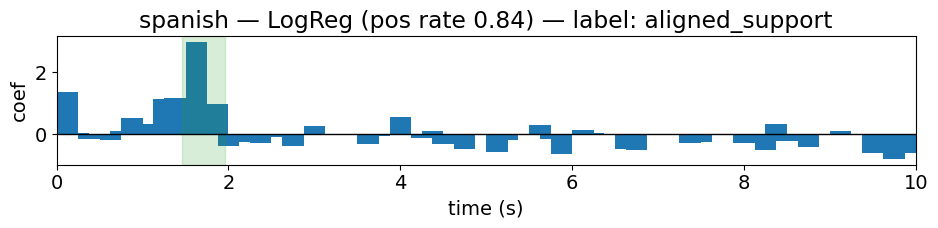

In [ ]:
plot_word_timeline_with_spans(
    'spanish',
    top_only=False,
    topk=12,           # number of bins to keep when top_only=True
    show_conf=True     # add the confidence value in the title
)



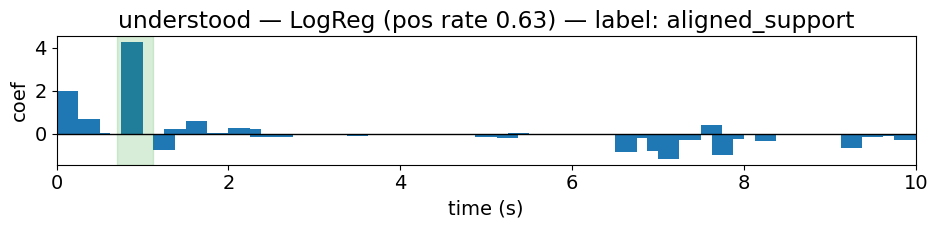

In [ ]:
plot_word_timeline_with_spans(
    'understood',
    top_only=False,
    topk=12,
    show_conf=True
)



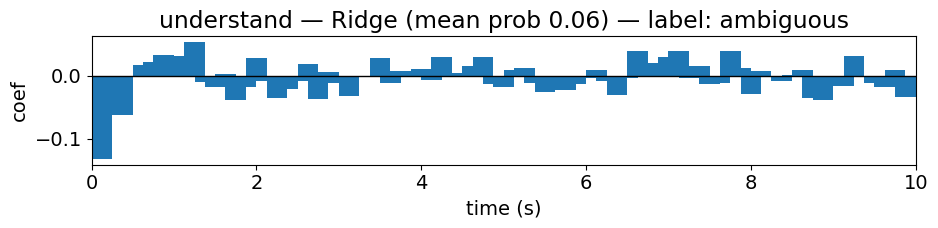

In [ ]:
plot_word_timeline_with_spans(
    'understand',
    top_only=False,
    topk=79,
    show_conf=True
)

In [ ]:
unique_words

['a',
 'and',
 'at',
 'but',
 'bye',
 'conga',
 "didn't",
 'english',
 'i',
 'knew',
 'know',
 'little',
 'mens',
 'my',
 'nobody',
 'package',
 'spanish',
 'that',
 'the',
 'time',
 'understand',
 'understood',
 "wasn't"]

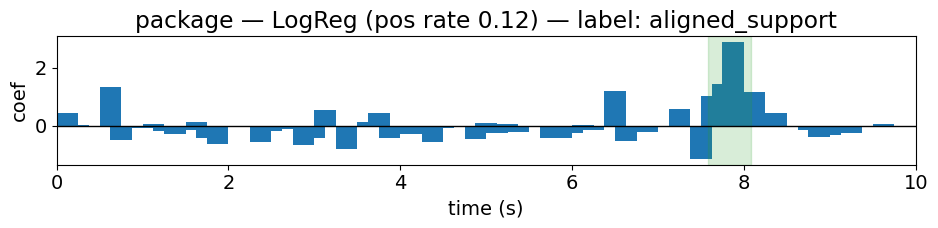

In [ ]:
plot_word_timeline_with_spans("package")

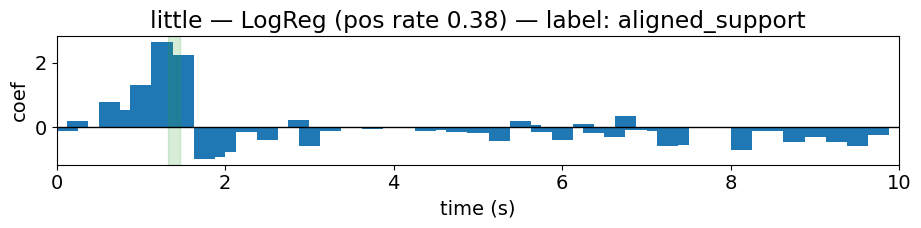

In [ ]:
plot_word_timeline_with_spans("little")

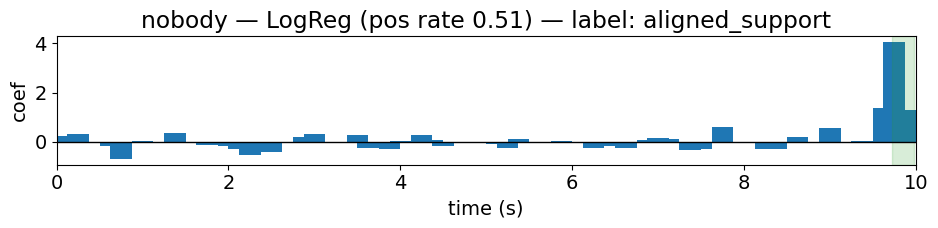

In [ ]:
plot_word_timeline_with_spans("nobody")

In [ ]:
def pos_rate_from_masks(word_norm):
    # presence across perturbations for this word
    y_bin = np.array([(wm.get(word_norm,0.0) >= WORD_PROB_T) for wm in hyps_maps], dtype=int)
    return float(y_bin.mean())


rows = []
for w in targets:
    m = token_metrics(w)
    if not m:
        continue
    pos_rate = pos_rate_from_masks(w)

    if (
        pos_rate < 0.5
        or (m["in_span_frac"] < 0.2 and m["strength"] < 10)
        or m["neg_in_span_frac"] >= 0.5
        or m["concentration"] >= 0.7
    ):
        decision = "review"
    else:
        decision = "ok"

    rows.append({
        "token": w,
        "pos_rate": round(pos_rate,3),
        "strength": round(m["strength"],3),
        "concentration": round(m["concentration"],3),
        "in_span_frac": round(m["in_span_frac"],3),
        "neg_in_span_frac": round(m["neg_in_span_frac"],3),
        "label": label_token(m),
        "model_used": m["model"],
        "decision": decision
    })

summary_df = pd.DataFrame(rows).sort_values(["decision","label","strength","in_span_frac"], ascending=[False, True, False, True])


In [ ]:
summary_df

,token,pos_rate,strength,concentration,in_span_frac,neg_in_span_frac,label,model_used,decision
9,little,0.378,22.153,0.119,0.294,0.000,"(aligned_support, 0.7175537086377478)",LogReg (pos rate 0.38),review
13,package,0.125,25.028,0.115,0.349,0.130,"(aligned_support, 0.7311564430457478)",LogReg (pos rate 0.12),review
0,a,0.470,17.507,0.243,0.457,0.000,"(aligned_support, 1.0)",LogReg (pos rate 0.47),review
18,understand,0.048,1.517,0.087,0.000,0.000,"(ambiguous, 0.28667298690180465)",Ridge (mean prob 0.06),review
6,i,0.963,1.569,0.057,0.175,0.033,"(ambiguous, 0.3597154635236096)",Ridge (mean prob 0.91),review
11,my,0.245,18.398,0.108,0.000,0.000,"(off_span_support, 1.0)",LogReg (pos rate 0.24),review
10,mens,0.000,0.163,0.041,0.000,0.000,"(weak_signal, 0.04078568646576399)",Ridge (mean prob 0.00),review
4,conga,0.000,0.375,0.046,0.000,0.000,"(weak_signal, 0.09377509091778143)",Ridge (mean prob 0.01),review
19,understood,0.632,16.672,0.255,0.256,0.006,"(aligned_support, 0.6173308241606467)",LogReg (pos rate 0.63),ok
2,at,0.792,21.199,0.118,0.263,0.000,"(aligned_support, 0.6351738662985087)",LogReg (pos rate 0.79),ok


In [ ]:
df_medium[df_medium['file']=='RayDolby_0'].text_B.values

array(["Well, the the various aspects of the first video recorder dating to 1953 54 Or no, even before that, you know, 53 54 is fair enough and then the Modulation system used the motor control system used for both the head and the capstan motor. The processing amplifier, which totally examined and reprocessed all of the signals that had to be sent out onto networks. The networks were very, very sensitive. if there's anything that was wrong in the signal, or they would just go crazy. I designed it."],
      dtype=object)

In [ ]:
df_medium[df_medium['file']=='RayDolby_0'].text_A.values

array(['Well, the various aspects of the first video recorder dating to 1953-54 Or no, even before that, yeah, 53-54 is fair enough. And then the modulation system used the motor control system used for both the head and the capstan motor, the processing amplifier which totally examined and reprocessed all of the signals that had to be sent out onto networks. The networks were very, very sensitive. if there anything that was wrong in the signal or they would just go crazy. I designed a'],
      dtype=object)

In [ ]:
df_medium[df_medium['file']=='RayDolby_0'].text_C.values

array(['Well, the various aspects of the first video recorder, dating to 1953-54, or no, even before that, yeah, that was 1953-54 is fair enough. And then the modulation system used, the motor control system used for both the head and the capstan motor. The processing amplifier, which totally examined and reprocessed all of the signals that had to be sent out onto networks. The networks were very very sensitive to anything that was wrong in the signal or they would just go crazy I designed it'],
      dtype=object)

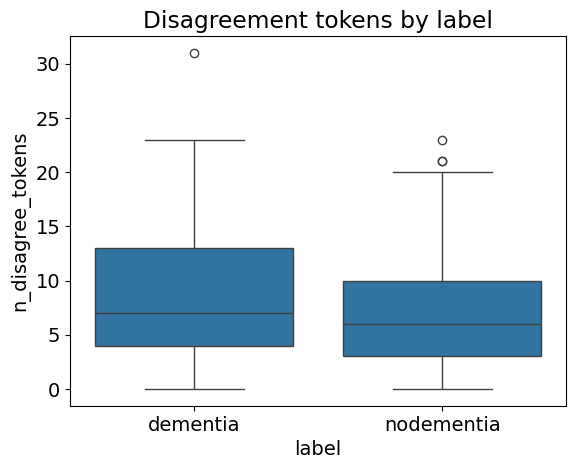

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df_medium, x="label", y="n_disagree_tokens")
plt.title("Disagreement tokens by label")
plt.show()


In [ ]:
df_medium.label.value_counts()

,count
label,
nodementia,119
dementia,95
